In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# LSTM - Palo Alto

This notebook goes through the process of training LSTM for Palo Alto. It uses dataset containing over 9 years of charging records in the city of Palo Alto. The model is trained to predict single next observation based on the previous records. The predictions are made on daily, weekly and monthly level to reflect companies needs for both short-term and long-term planning. Models are trained on each of the stations separately to achieve better performance.

### Data processing

In [89]:
# Load dataset
df = pd.read_csv('palo_alto_old_cleaned.csv', index_col=[0])

# Drop Sherman (has only 39 chargings)
df = df[df['Station Name'] != 'SHERMAN']

# Convert date
df['Date'] = pd.to_datetime(df['Date'])

C:\Users\balda\AppData\Local\Temp\ipykernel_14856\3552963377.py:2: DtypeWarning: Columns (30,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('palo_alto_old_cleaned.csv', index_col=[0])


In [90]:
df['Date'].min(), df['Date'].max()

(Timestamp('2011-07-29 00:00:00'), Timestamp('2020-12-31 00:00:00'))

As mentioned, dataset is almost 9 and half years long. 

In [91]:
# Split data per station and create dictionary for easy access
stations = df['Station Name'].unique()
stations_dict = {}

for station in stations:
    stations_dict[station] = {'data':pd.DataFrame(), 'daily':pd.DataFrame(), 'weekly':pd.DataFrame(), 'monthly':pd.DataFrame()}
    stations_dict[station]['data'] = df[df['Station Name'] == station]

In [92]:
# Loop over stations and process the data further creating necessary columns
for station in stations:
    print(station)
    df_temp = stations_dict[station]['data'].copy()
    
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    df_temp['Year-Month'] = df_temp['Date'].dt.strftime('%Y-%m')

    # Define the start date and end date
    start_date = df_temp['Date'].min()
    end_date = df_temp['Date'].max()

    # Calculate the number of weeks from the start date for each date
    df_temp['Week_index'] = (df_temp['Date'] - start_date).dt.days // 7

    stations_dict[station]['data'] = df_temp

HAMILTON
HIGH
BRYANT
MPL
RINCONADA LIB
WEBSTER
TED THOMPSON
CAMBRIDGE


There are 8 different stations. Model will be trained to predict each of the stations energy demand separately. One station SHERMAN has been dropped due to insufficient length of records.

Each timeframe model (daily, weekly, monthly) requires appropriately grouped data. The following sections process the data so that each of the records represents one observation (e.g. summed energy demand from all chargings for a day).

### Daily data processing

In [93]:
for station in stations:

    df_temp = stations_dict[station]['data'].copy()
    daily = df_temp.groupby(['Date', 'Station Name'])['Energy (kWh)'].sum().reset_index()

    # Define the complete date range
    start_date = df_temp['Date'].min()
    end_date = df_temp['Date'].max()
    date_range = pd.date_range(start=start_date, end=end_date)

    station_data = pd.DataFrame({'Date': date_range, 'Station Name': station})

    # Merge the complete data with the daily DataFrame to fill in missing values with 0
    daily_merged = pd.merge(station_data, daily, on=['Date', 'Station Name'], how='left')
    daily_merged['Energy (kWh)'] = daily_merged['Energy (kWh)'].fillna(0)

    stations_dict[station]['daily'] = daily_merged

### Weekly data processing

In [94]:
for station in stations:

    df_temp = stations_dict[station]['data'].copy()
    
    # Group by Week_index and Station Name to get weekly energy consumption
    weekly = df_temp.groupby(['Week_index', 'Station Name'])['Energy (kWh)'].sum().reset_index()

    # Define the complete week index range
    start_week = df_temp['Week_index'].min()
    end_week = df_temp['Week_index'].max()
    week_range = range(start_week, end_week + 1)

    station_data = pd.DataFrame({'Week_index': week_range, 'Station Name': station})

    # Merge the complete data with the weekly DataFrame to fill in missing values with 0
    weekly_merged = pd.merge(station_data, weekly, on=['Week_index', 'Station Name'], how='left')
    weekly_merged['Energy (kWh)'] = weekly_merged['Energy (kWh)'].fillna(0)

    stations_dict[station]['weekly'] = weekly_merged

### Monthly data processing

In [95]:
for station in stations:

    df_temp = stations_dict[station]['data'].copy()
    
    # Group by 'Year-Month' and 'Station Name' to get monthly energy consumption
    monthly = df_temp.groupby(['Year-Month', 'Station Name'])['Energy (kWh)'].sum().reset_index()

    # Define the complete 'Year-Month' range
    start_year_month = df_temp['Year-Month'].min()
    end_year_month = df_temp['Year-Month'].max()
    year_month_range = pd.date_range(start=start_year_month, end=end_year_month, freq='MS').strftime('%Y-%m')

    station_data = pd.DataFrame({'Year-Month': year_month_range, 'Station Name': station})

    # Merge the complete data with the monthly DataFrame to fill in missing values with 0
    monthly_merged = pd.merge(station_data, monthly, on=['Year-Month', 'Station Name'], how='left')
    monthly_merged['Energy (kWh)'] = monthly_merged['Energy (kWh)'].fillna(0)

    stations_dict[station]['monthly'] = monthly_merged

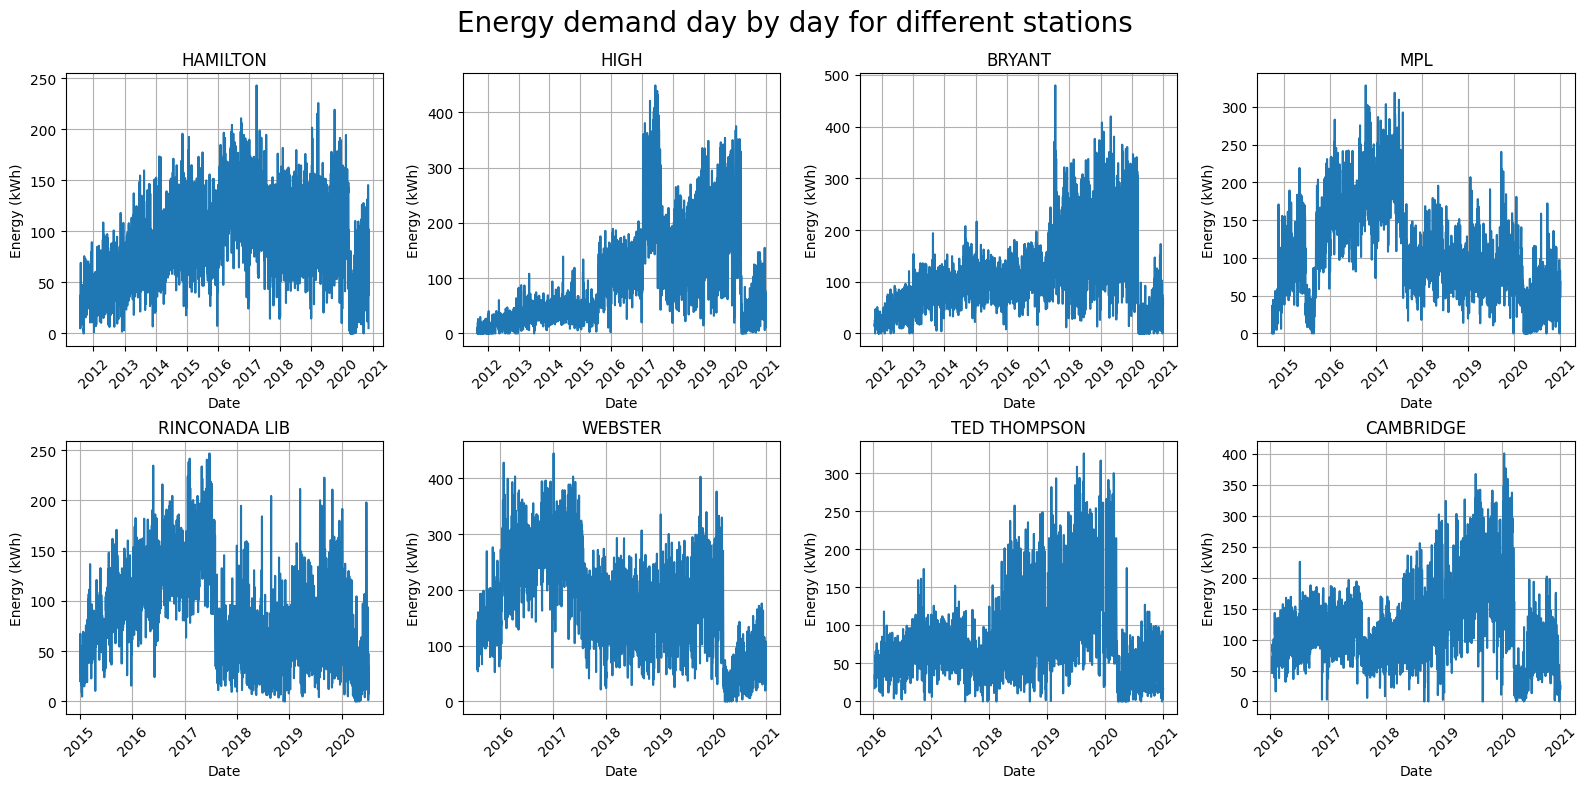

In [97]:
# Define the number of rows and columns for the subplots
num_rows = 2
num_cols = 4

# Create a figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 8))
axs = axs.flatten()

# Iterate over each station and plot on a separate subplot
for i, station in enumerate(stations):
    plot_df = stations_dict[station]['daily']
    ax = axs[i]
    ax.plot(plot_df['Date'], plot_df['Energy (kWh)'])
    ax.set_title(station)
    ax.set_xlabel('Date')
    ax.set_ylabel('Energy (kWh)')
    ax.grid(True)
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Energy demand day by day for different stations', fontsize=20)
plt.show()

Energy consumption varies a lot between the days Local trends lasting even couple of months are observed. Its hard to recognize any cyclic behaviour of the data which makes the prediction task difficult. It can also be seen that right after 2020 started there was a very signifcant drop in demand most certainly caused by covid pandemia.

### Model definition

The network will contain an lstm layer and a linear layer on top of it. The model is further initiated in the train function with `input_size` = 1 as it aims at predicting the single next observation, `hidden_size` = 64 indicating number of neurons in the hidden layer, `num_layer` = 1 as only one lstm layer is used. Dropout of `0.5` is also implemented to help with the regularization by randomly deactivating portion of the neurons in the hidden layer.

In [98]:
class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units 
      # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        # extract only the last time step
        out = out[:, -1, :]
        out = self.linear(out)
        return out

In [99]:
# Use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


The following training loop performs the following operations: 
- scales the data to 0-1, 
- creates a sequence of chosen length reflecting the lookback period
- split data into train and test sets
- initiates model
- trains the model evaluating both train and test error
- saves necessary outputs

In [128]:
def train_lstm(df_dict, type, sequence_length, stations, num_epochs, predictions_dict, test_obs):
    for station in stations:
        print('\n', station, '\n')
        temp_df = df_dict[station][type]['Energy (kWh)']

        # Scaling dataset
        reshaped_data = np.reshape(temp_df, (-1,1))
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(reshaped_data)

        # Create sequences and labels for training data
        sequence_length = sequence_length  # Number of time steps to look back
        X, y = [], []
        for i in range(len(scaled_data) - sequence_length):
            X.append(scaled_data[i:i+sequence_length])
            y.append(scaled_data[i+sequence_length])
        X, y = np.array(X), np.array(y)

        # Splitting the dataset
        X_train = X[:-test_obs]
        y_train = y[:-test_obs]
        X_test = X[-test_obs:]
        y_test = y[-test_obs:]
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
        # Convert data to PyTorch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.float32)
        X_train.shape,y_train.shape

        input_size = 1
        num_layers = 1
        hidden_size = 64
        
        # Define the model, loss function, and optimizer
        model = LSTMModel(input_size, hidden_size, num_layers).to(device)
        
        loss_fn = torch.nn.MSELoss(reduction='mean')
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        batch_size = 15
        # Create DataLoader for batch training
        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        
        # Create DataLoader for batch training
        test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        num_epochs = num_epochs
        train_hist = []
        test_hist = []
        # Training loop
        for epoch in range(num_epochs):
            total_loss = 0.0

            # Training
            model.train()
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                predictions = model(batch_X)
                loss = loss_fn(predictions, batch_y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Calculate average training loss and accuracy
            average_loss = total_loss / len(train_loader)
            train_hist.append(average_loss)

            # Validation on test data
            model.eval()
            with torch.no_grad():
                total_test_loss = 0.0

                for batch_X_test, batch_y_test in test_loader:
                    batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                    predictions_test = model(batch_X_test)
                    test_loss = loss_fn(predictions_test, batch_y_test)

                    total_test_loss += test_loss.item()

                # Calculate average test loss and accuracy
                average_test_loss = total_test_loss / len(test_loader)
                test_hist.append(average_test_loss)
            if (epoch+1)%10==0:
                print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

        #training plot
        x = np.linspace(1,num_epochs,num_epochs)
        plt.plot(x, train_hist, scalex=True, label="Training loss")
        plt.plot(x, test_hist, label="Test loss")
        plt.suptitle(station)
        plt.legend()
        plt.show()

        # # Save the model's state dictionary to a file
        # if station == 'HAMILTON':
        #     torch.save(model.state_dict(), f'lstm_model_monthly_{station}.pth')

        # # Save the model's state dictionary to a file
        # if station == 'MPL':
        #     torch.save(model.state_dict(), f'lstm_model_monthly_{station}.pth')
        
        # Set the model to evaluation mode
        model.eval()

        # Move input tensor to the same device as model's parameters
        X_test = X_test.to(device)

        # Pass the entire test set through the model to obtain predictions
        with torch.no_grad():
            # Obtain predictions for the entire test set
            predictions_test = model(X_test)
            
            # Convert predictions from tensors to NumPy arrays
            predictions_test = predictions_test.cpu().numpy()

        # Reverse predictions
        y_test_reversed = scaler.inverse_transform(y_test.reshape(-1, 1))
        predictions_reversed = scaler.inverse_transform(predictions_test.reshape(-1, 1))

        # Save y_test and predictions
        predictions_dict[station]['y_pred'] = predictions_reversed
        predictions_dict[station]['y_test'] = y_test_reversed

        # Calculate mean squared error
        mse = mean_squared_error(y_test_reversed, predictions_reversed)

        # Calculate root mean squared error
        rmse = np.sqrt(mse)

        print(f"{station} Root Mean Squared Error (RMSE):", rmse)
        predictions_dict[station]['rmse'] = rmse

Training of each model has been evaluated for various combinations of hyperparameters. The following results present only the final chosen models.

### Daily LSTM training

Daily model is trained to predict based on 30 previous observations. Test set contains last 30 observations (rest is used for training). It is trained only for 50 epochs to avoid overfitting. The training output has been colapsed as it used only for diagnostics. Results are shown at the end.

In [101]:
# Initialize dict for storing predictions
daily_predictions_dict = {}
for station in stations:
    daily_predictions_dict[station] = {'y_test':[], 'y_pred':[], 'rmse':0}


 HAMILTON 

(3327, 30, 1) (3327, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0172, Test Loss: 0.0203
Epoch [20/50] - Training Loss: 0.0154, Test Loss: 0.0211
Epoch [30/50] - Training Loss: 0.0126, Test Loss: 0.0199
Epoch [40/50] - Training Loss: 0.0122, Test Loss: 0.0202
Epoch [50/50] - Training Loss: 0.0121, Test Loss: 0.0203


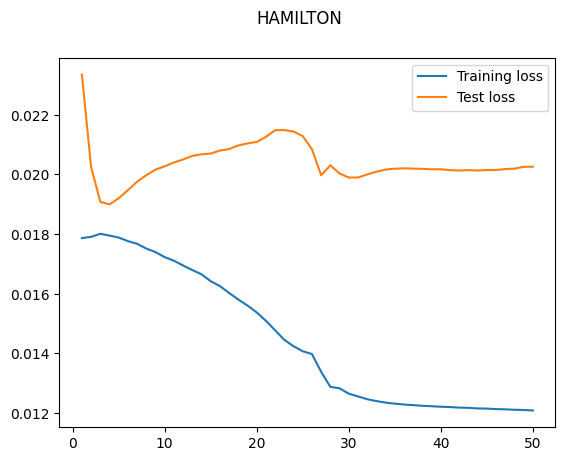

HAMILTON Root Mean Squared Error (RMSE): 34.61325929531799

 HIGH 

(3349, 30, 1) (3349, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0103, Test Loss: 0.0063
Epoch [20/50] - Training Loss: 0.0075, Test Loss: 0.0058
Epoch [30/50] - Training Loss: 0.0065, Test Loss: 0.0060
Epoch [40/50] - Training Loss: 0.0063, Test Loss: 0.0061
Epoch [50/50] - Training Loss: 0.0062, Test Loss: 0.0062


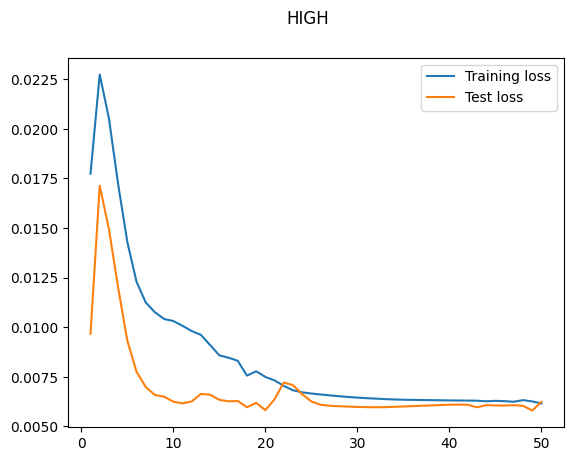

HIGH Root Mean Squared Error (RMSE): 35.409879789150374

 BRYANT 

(3311, 30, 1) (3311, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0110, Test Loss: 0.0061
Epoch [20/50] - Training Loss: 0.0070, Test Loss: 0.0064
Epoch [30/50] - Training Loss: 0.0067, Test Loss: 0.0066
Epoch [40/50] - Training Loss: 0.0066, Test Loss: 0.0067
Epoch [50/50] - Training Loss: 0.0064, Test Loss: 0.0066


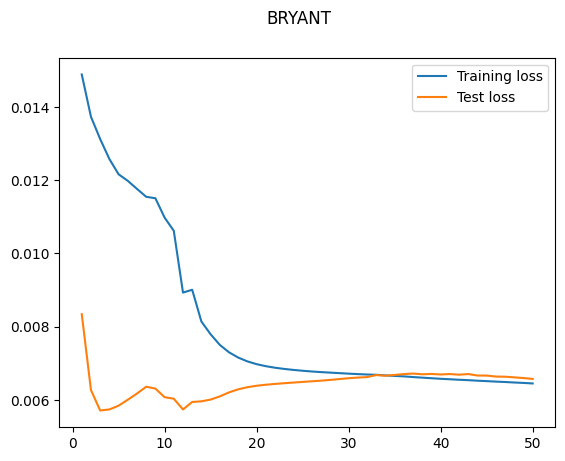

BRYANT Root Mean Squared Error (RMSE): 38.885083530805936

 MPL 

(2231, 30, 1) (2231, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0149, Test Loss: 0.0048
Epoch [20/50] - Training Loss: 0.0115, Test Loss: 0.0052
Epoch [30/50] - Training Loss: 0.0115, Test Loss: 0.0050
Epoch [40/50] - Training Loss: 0.0115, Test Loss: 0.0050
Epoch [50/50] - Training Loss: 0.0114, Test Loss: 0.0050


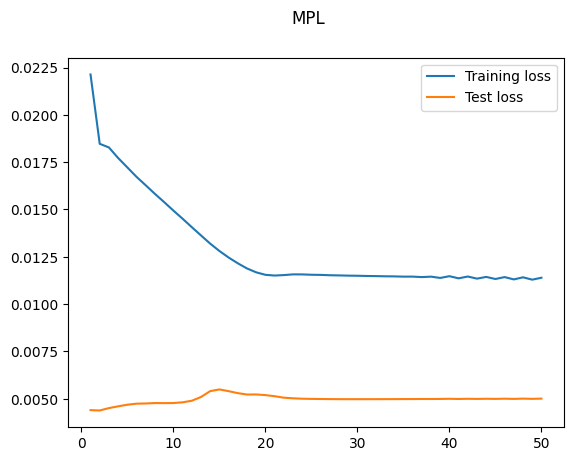

MPL Root Mean Squared Error (RMSE): 23.241876004816604

 RINCONADA LIB 

(1952, 30, 1) (1952, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0296, Test Loss: 0.0247
Epoch [20/50] - Training Loss: 0.0205, Test Loss: 0.0265
Epoch [30/50] - Training Loss: 0.0197, Test Loss: 0.0274
Epoch [40/50] - Training Loss: 0.0194, Test Loss: 0.0273
Epoch [50/50] - Training Loss: 0.0191, Test Loss: 0.0269


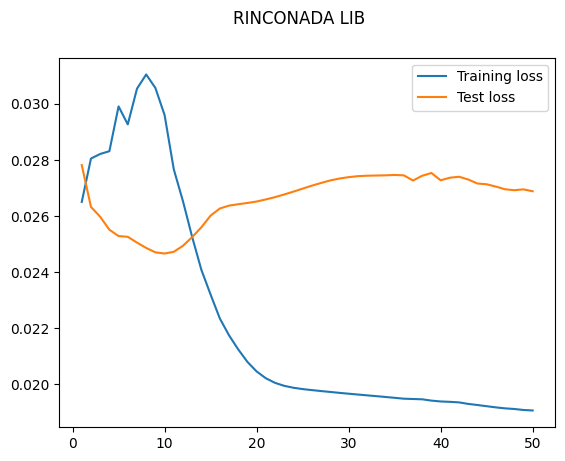

RINCONADA LIB Root Mean Squared Error (RMSE): 40.445204634198944

 WEBSTER 

(1923, 30, 1) (1923, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0198, Test Loss: 0.0105
Epoch [20/50] - Training Loss: 0.0123, Test Loss: 0.0092
Epoch [30/50] - Training Loss: 0.0119, Test Loss: 0.0088
Epoch [40/50] - Training Loss: 0.0116, Test Loss: 0.0086
Epoch [50/50] - Training Loss: 0.0114, Test Loss: 0.0085


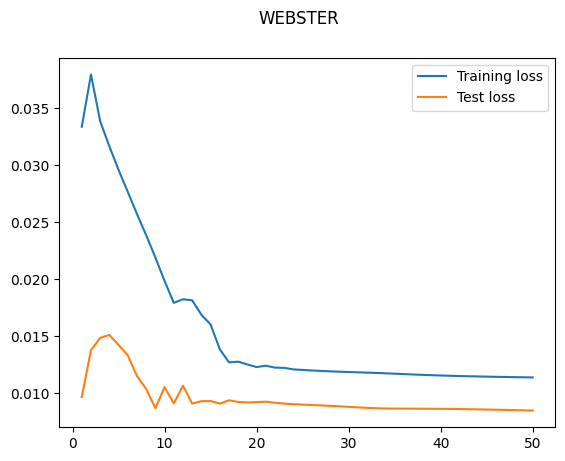

WEBSTER Root Mean Squared Error (RMSE): 40.987519331827656

 TED THOMPSON 

(1754, 30, 1) (1754, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0191, Test Loss: 0.0103
Epoch [20/50] - Training Loss: 0.0132, Test Loss: 0.0078
Epoch [30/50] - Training Loss: 0.0127, Test Loss: 0.0079
Epoch [40/50] - Training Loss: 0.0125, Test Loss: 0.0076
Epoch [50/50] - Training Loss: 0.0123, Test Loss: 0.0075


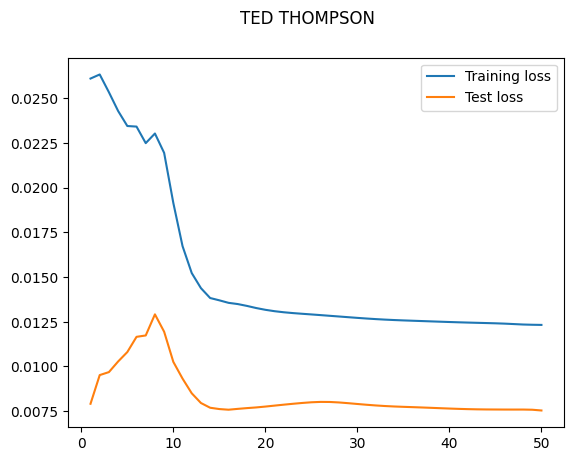

TED THOMPSON Root Mean Squared Error (RMSE): 28.28741218600907

 CAMBRIDGE 

(1754, 30, 1) (1754, 1) (30, 30, 1) (30, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0187, Test Loss: 0.0117
Epoch [20/50] - Training Loss: 0.0129, Test Loss: 0.0094
Epoch [30/50] - Training Loss: 0.0117, Test Loss: 0.0134
Epoch [40/50] - Training Loss: 0.0115, Test Loss: 0.0130
Epoch [50/50] - Training Loss: 0.0113, Test Loss: 0.0129


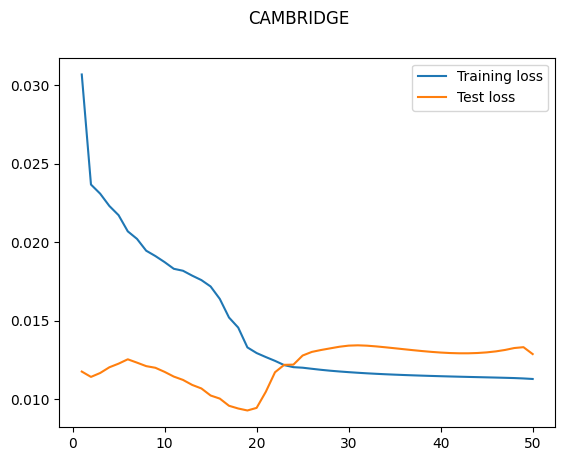

CAMBRIDGE Root Mean Squared Error (RMSE): 45.476346550621955


In [103]:
train_lstm(df_dict=stations_dict, type='daily', sequence_length=30, stations=stations, 
           num_epochs=50, predictions_dict=daily_predictions_dict, test_obs=30)

In [104]:
# File path to save the dictionary
file_path = 'daily_predictions_palo_alto.pkl'

# Save outputs to use them later
with open(file_path, 'wb') as file:
    pickle.dump(daily_predictions_dict, file)

print(f"Dictionary saved to '{file_path}'")

Dictionary saved to 'daily_predictions_palo_alto.pkl'


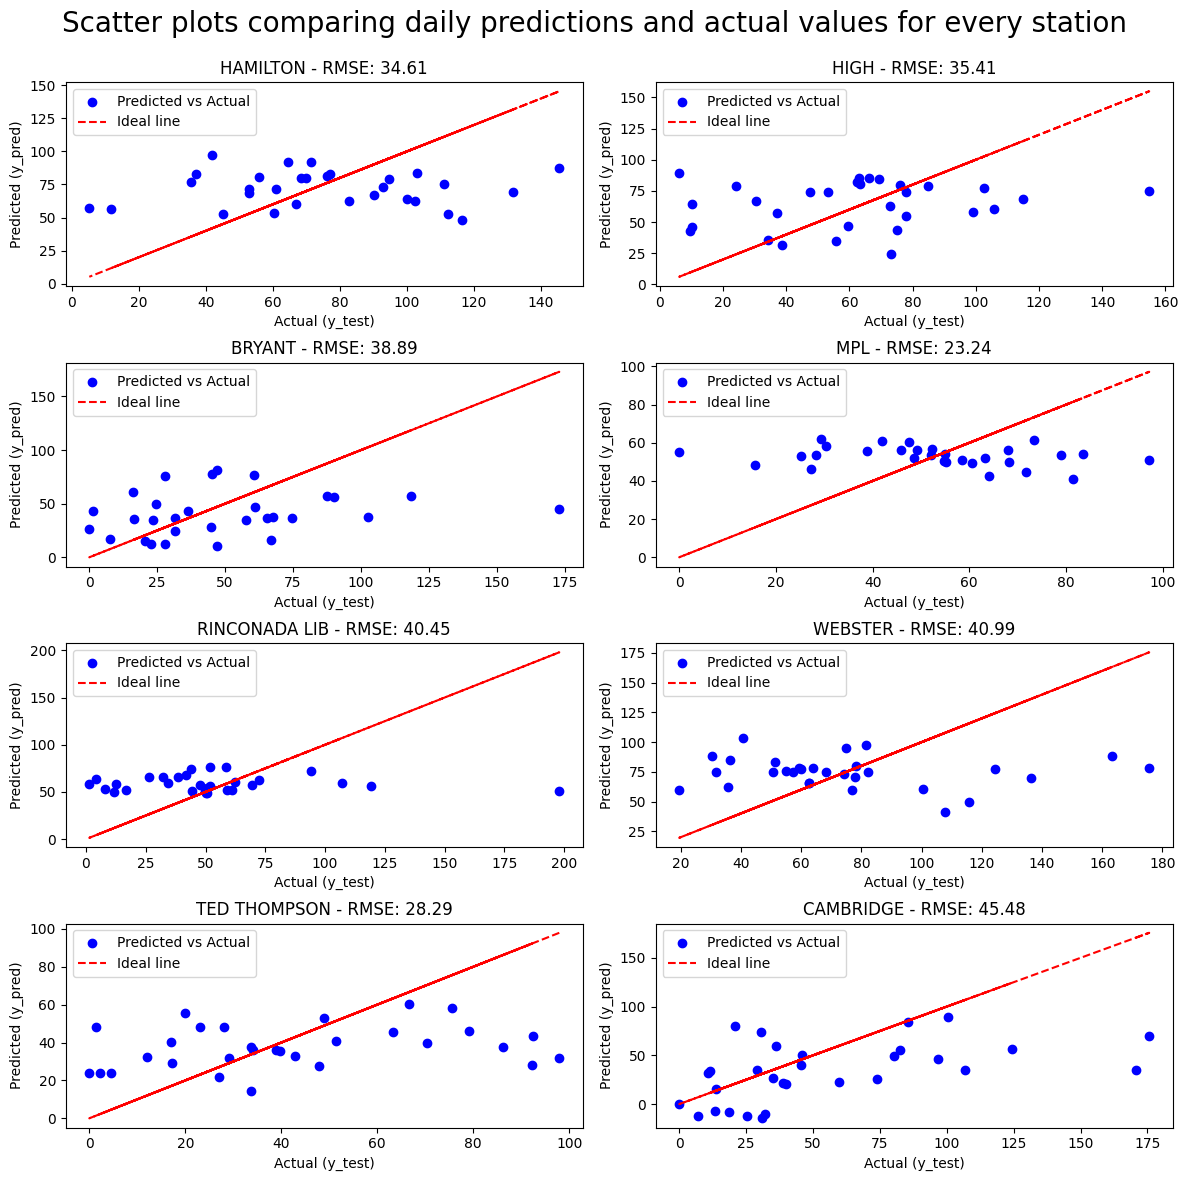

In [116]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 2

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(daily_predictions_dict.keys()):
    # Get data for the current station
    station_data = daily_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot y_pred against y_test
    axs[i].scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    axs[i].plot(y_test, y_test, color='red', linestyle='--', label='Ideal line')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Actual (y_test)')
    axs[i].set_ylabel('Predicted (y_pred)')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Scatter plots comparing daily predictions and actual values for every station', fontsize=20)
plt.show()

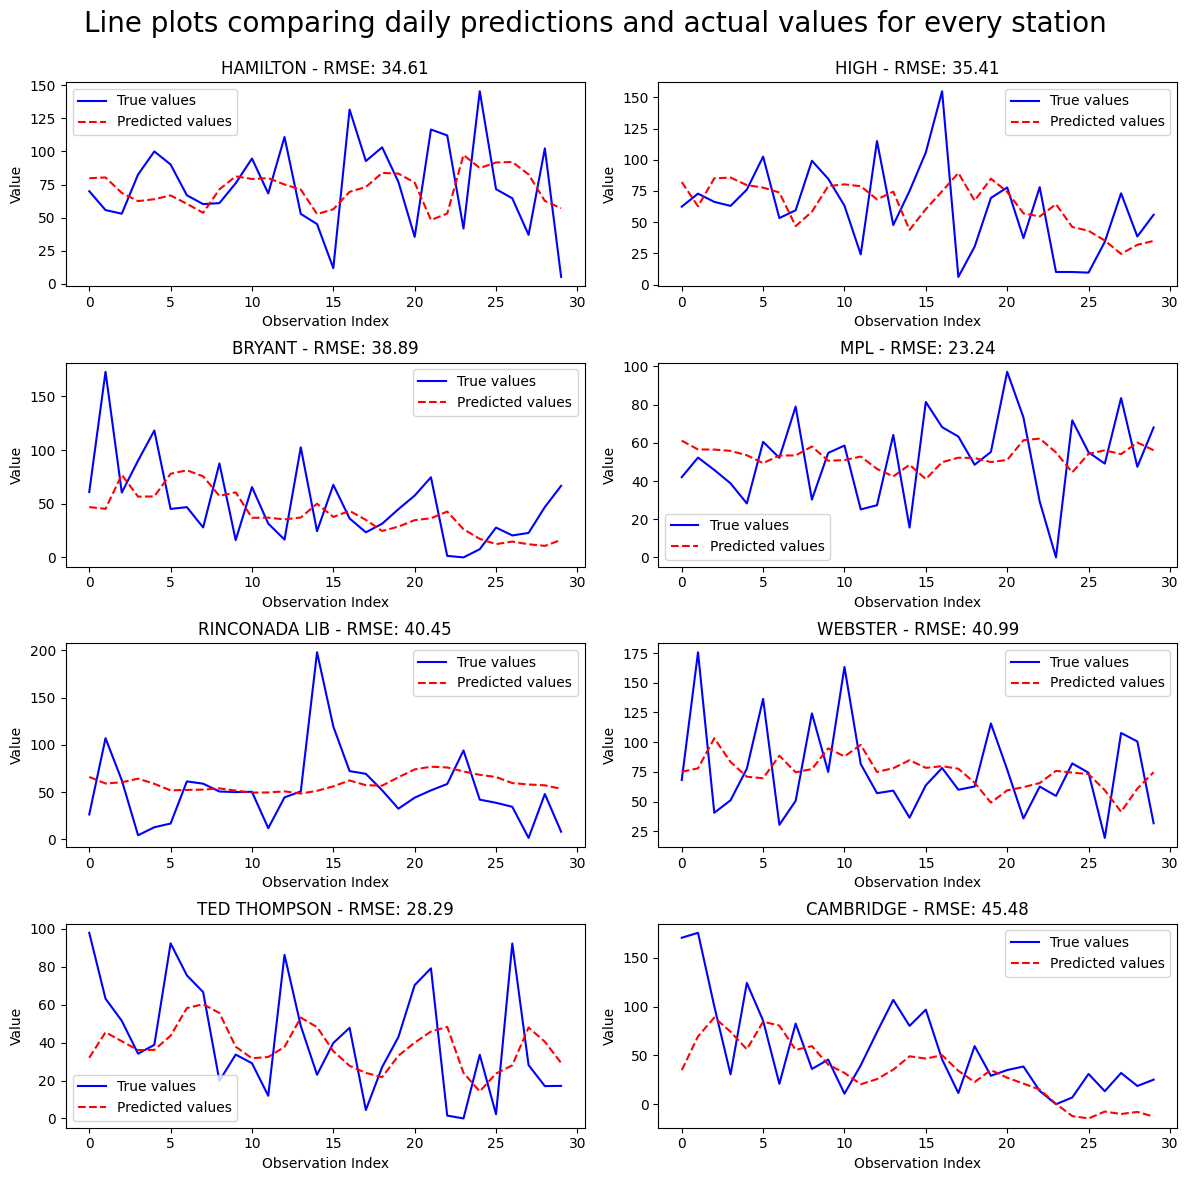

In [117]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 2

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(daily_predictions_dict.keys()):
    # Get data for the current station
    station_data = daily_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot true values and predicted values against the index of observations
    x = np.arange(len(y_test))
    axs[i].plot(x, y_test, color='blue', label='True values')
    axs[i].plot(x, y_pred, color='red', linestyle='--', label='Predicted values')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Observation Index')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Line plots comparing daily predictions and actual values for every station', fontsize=20)
plt.show()


The results are satisfying. Given the highly irregular variability predictions seem to follow the patterns decently. Some stations like MPL or TED THOMPSON outperform the other. RMSE is rather low for all of the stations.

### Weekly LSTM model

Weekly model is trained to predict also based on 30 previous observations. Test set contains last 12 observations (rest is used for training). This time the model is trained twice as long as the convergence has not been reached within 50 epochs. The training output has been colapsed as it used only for diagnostics. Results are shown at the end.

In [113]:
# Initialize dict for storing predictions
weekly_predictions_dict = {}
for station in stations:
    weekly_predictions_dict[station] = {'y_test':[], 'y_pred':[], 'rmse':0}


 HAMILTON 

(442, 30, 1) (442, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0231, Test Loss: 0.0168
Epoch [20/100] - Training Loss: 0.0125, Test Loss: 0.0045
Epoch [30/100] - Training Loss: 0.0103, Test Loss: 0.0041
Epoch [40/100] - Training Loss: 0.0098, Test Loss: 0.0045
Epoch [50/100] - Training Loss: 0.0096, Test Loss: 0.0048
Epoch [60/100] - Training Loss: 0.0093, Test Loss: 0.0052
Epoch [70/100] - Training Loss: 0.0092, Test Loss: 0.0059
Epoch [80/100] - Training Loss: 0.0090, Test Loss: 0.0064
Epoch [90/100] - Training Loss: 0.0090, Test Loss: 0.0056
Epoch [100/100] - Training Loss: 0.0090, Test Loss: 0.0061


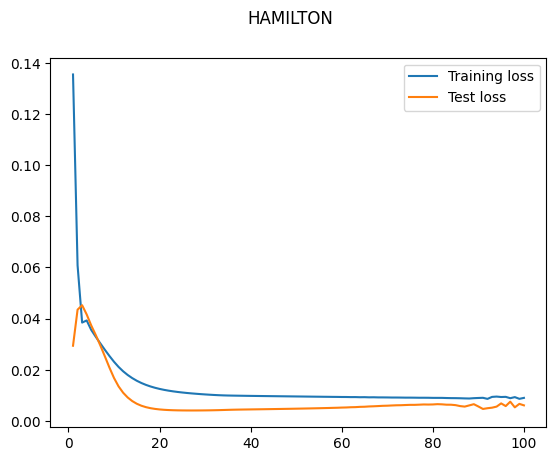

HAMILTON Root Mean Squared Error (RMSE): 78.79836210768866

 HIGH 

(445, 30, 1) (445, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0120, Test Loss: 0.0052
Epoch [20/100] - Training Loss: 0.0075, Test Loss: 0.0031
Epoch [30/100] - Training Loss: 0.0065, Test Loss: 0.0030
Epoch [40/100] - Training Loss: 0.0061, Test Loss: 0.0030
Epoch [50/100] - Training Loss: 0.0058, Test Loss: 0.0031
Epoch [60/100] - Training Loss: 0.0056, Test Loss: 0.0031
Epoch [70/100] - Training Loss: 0.0055, Test Loss: 0.0031
Epoch [80/100] - Training Loss: 0.0053, Test Loss: 0.0031
Epoch [90/100] - Training Loss: 0.0052, Test Loss: 0.0032
Epoch [100/100] - Training Loss: 0.0050, Test Loss: 0.0029


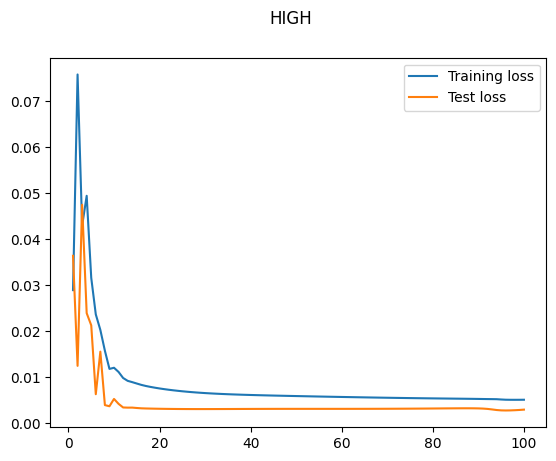

HIGH Root Mean Squared Error (RMSE): 124.36009504756969

 BRYANT 

(440, 30, 1) (440, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0123, Test Loss: 0.0158
Epoch [20/100] - Training Loss: 0.0078, Test Loss: 0.0052
Epoch [30/100] - Training Loss: 0.0074, Test Loss: 0.0046
Epoch [40/100] - Training Loss: 0.0070, Test Loss: 0.0042
Epoch [50/100] - Training Loss: 0.0067, Test Loss: 0.0038
Epoch [60/100] - Training Loss: 0.0064, Test Loss: 0.0036
Epoch [70/100] - Training Loss: 0.0063, Test Loss: 0.0035
Epoch [80/100] - Training Loss: 0.0063, Test Loss: 0.0034
Epoch [90/100] - Training Loss: 0.0063, Test Loss: 0.0033
Epoch [100/100] - Training Loss: 0.0062, Test Loss: 0.0032


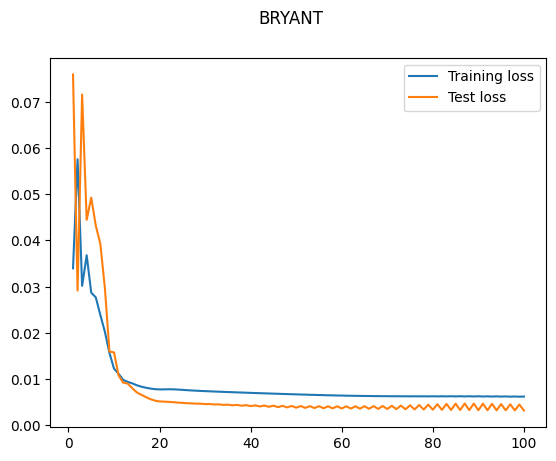

BRYANT Root Mean Squared Error (RMSE): 130.4194992398309

 MPL 

(286, 30, 1) (286, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0234, Test Loss: 0.0129
Epoch [20/100] - Training Loss: 0.0099, Test Loss: 0.0042
Epoch [30/100] - Training Loss: 0.0088, Test Loss: 0.0036
Epoch [40/100] - Training Loss: 0.0082, Test Loss: 0.0035
Epoch [50/100] - Training Loss: 0.0078, Test Loss: 0.0033
Epoch [60/100] - Training Loss: 0.0075, Test Loss: 0.0032
Epoch [70/100] - Training Loss: 0.0073, Test Loss: 0.0032
Epoch [80/100] - Training Loss: 0.0071, Test Loss: 0.0032
Epoch [90/100] - Training Loss: 0.0070, Test Loss: 0.0035
Epoch [100/100] - Training Loss: 0.0070, Test Loss: 0.0032


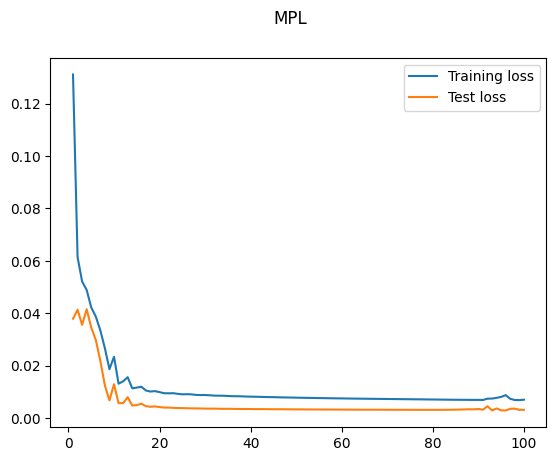

MPL Root Mean Squared Error (RMSE): 92.35864816226668

 RINCONADA LIB 

(246, 30, 1) (246, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0190, Test Loss: 0.0184
Epoch [20/100] - Training Loss: 0.0112, Test Loss: 0.0153
Epoch [30/100] - Training Loss: 0.0090, Test Loss: 0.0171
Epoch [40/100] - Training Loss: 0.0085, Test Loss: 0.0175
Epoch [50/100] - Training Loss: 0.0083, Test Loss: 0.0170
Epoch [60/100] - Training Loss: 0.0080, Test Loss: 0.0164
Epoch [70/100] - Training Loss: 0.0077, Test Loss: 0.0157
Epoch [80/100] - Training Loss: 0.0087, Test Loss: 0.0153
Epoch [90/100] - Training Loss: 0.0076, Test Loss: 0.0154
Epoch [100/100] - Training Loss: 0.0073, Test Loss: 0.0160


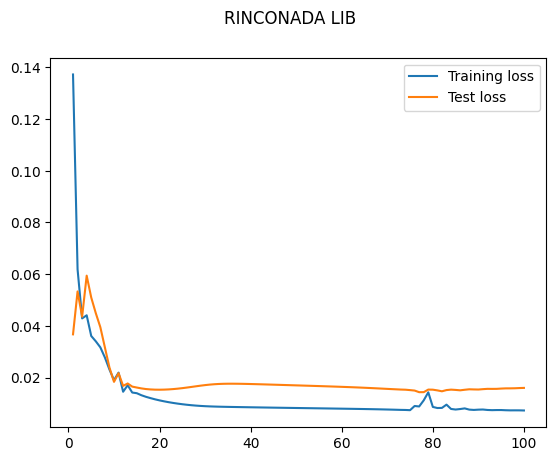

RINCONADA LIB Root Mean Squared Error (RMSE): 158.13929864043644

 WEBSTER 

(242, 30, 1) (242, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0178, Test Loss: 0.0102
Epoch [20/100] - Training Loss: 0.0128, Test Loss: 0.0067
Epoch [30/100] - Training Loss: 0.0113, Test Loss: 0.0060
Epoch [40/100] - Training Loss: 0.0104, Test Loss: 0.0055
Epoch [50/100] - Training Loss: 0.0098, Test Loss: 0.0051
Epoch [60/100] - Training Loss: 0.0094, Test Loss: 0.0048
Epoch [70/100] - Training Loss: 0.0092, Test Loss: 0.0047
Epoch [80/100] - Training Loss: 0.0090, Test Loss: 0.0047
Epoch [90/100] - Training Loss: 0.0087, Test Loss: 0.0046
Epoch [100/100] - Training Loss: 0.0084, Test Loss: 0.0045


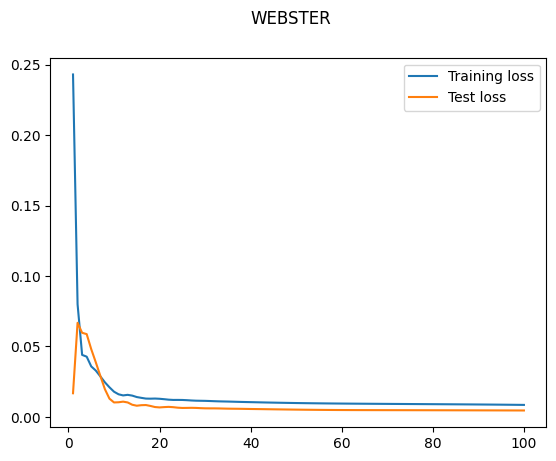

WEBSTER Root Mean Squared Error (RMSE): 142.57226722422058

 TED THOMPSON 

(218, 30, 1) (218, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0262, Test Loss: 0.0387
Epoch [20/100] - Training Loss: 0.0158, Test Loss: 0.0135
Epoch [30/100] - Training Loss: 0.0136, Test Loss: 0.0109
Epoch [40/100] - Training Loss: 0.0124, Test Loss: 0.0095
Epoch [50/100] - Training Loss: 0.0117, Test Loss: 0.0085
Epoch [60/100] - Training Loss: 0.0112, Test Loss: 0.0077
Epoch [70/100] - Training Loss: 0.0109, Test Loss: 0.0070
Epoch [80/100] - Training Loss: 0.0107, Test Loss: 0.0065
Epoch [90/100] - Training Loss: 0.0104, Test Loss: 0.0063
Epoch [100/100] - Training Loss: 0.0101, Test Loss: 0.0059


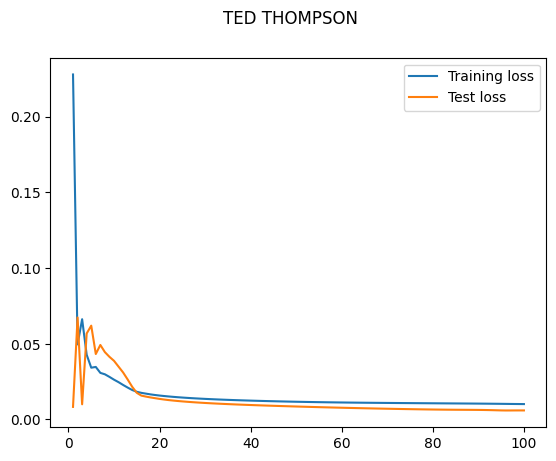

TED THOMPSON Root Mean Squared Error (RMSE): 114.20773040853344

 CAMBRIDGE 

(218, 30, 1) (218, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0315, Test Loss: 0.0597
Epoch [20/100] - Training Loss: 0.0204, Test Loss: 0.0326
Epoch [30/100] - Training Loss: 0.0156, Test Loss: 0.0218
Epoch [40/100] - Training Loss: 0.0138, Test Loss: 0.0182
Epoch [50/100] - Training Loss: 0.0127, Test Loss: 0.0160
Epoch [60/100] - Training Loss: 0.0121, Test Loss: 0.0144
Epoch [70/100] - Training Loss: 0.0118, Test Loss: 0.0134
Epoch [80/100] - Training Loss: 0.0116, Test Loss: 0.0128
Epoch [90/100] - Training Loss: 0.0113, Test Loss: 0.0123
Epoch [100/100] - Training Loss: 0.0110, Test Loss: 0.0118


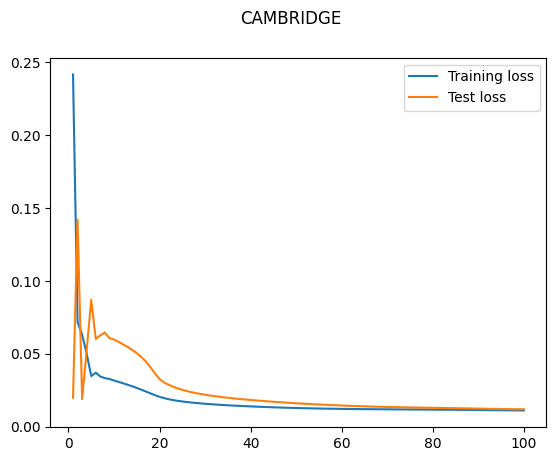

CAMBRIDGE Root Mean Squared Error (RMSE): 209.17297882366324


In [114]:
train_lstm(df_dict=stations_dict, type='weekly', sequence_length=30, stations=stations, 
           num_epochs=100, predictions_dict=weekly_predictions_dict, test_obs=12)

In [115]:
# File path to save the dictionary
file_path = 'weekly_predictions_palo_alto.pkl'

# Save the dictionary to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(weekly_predictions_dict, file)

print(f"Dictionary saved to '{file_path}'")

Dictionary saved to 'weekly_predictions_palo_alto.pkl'


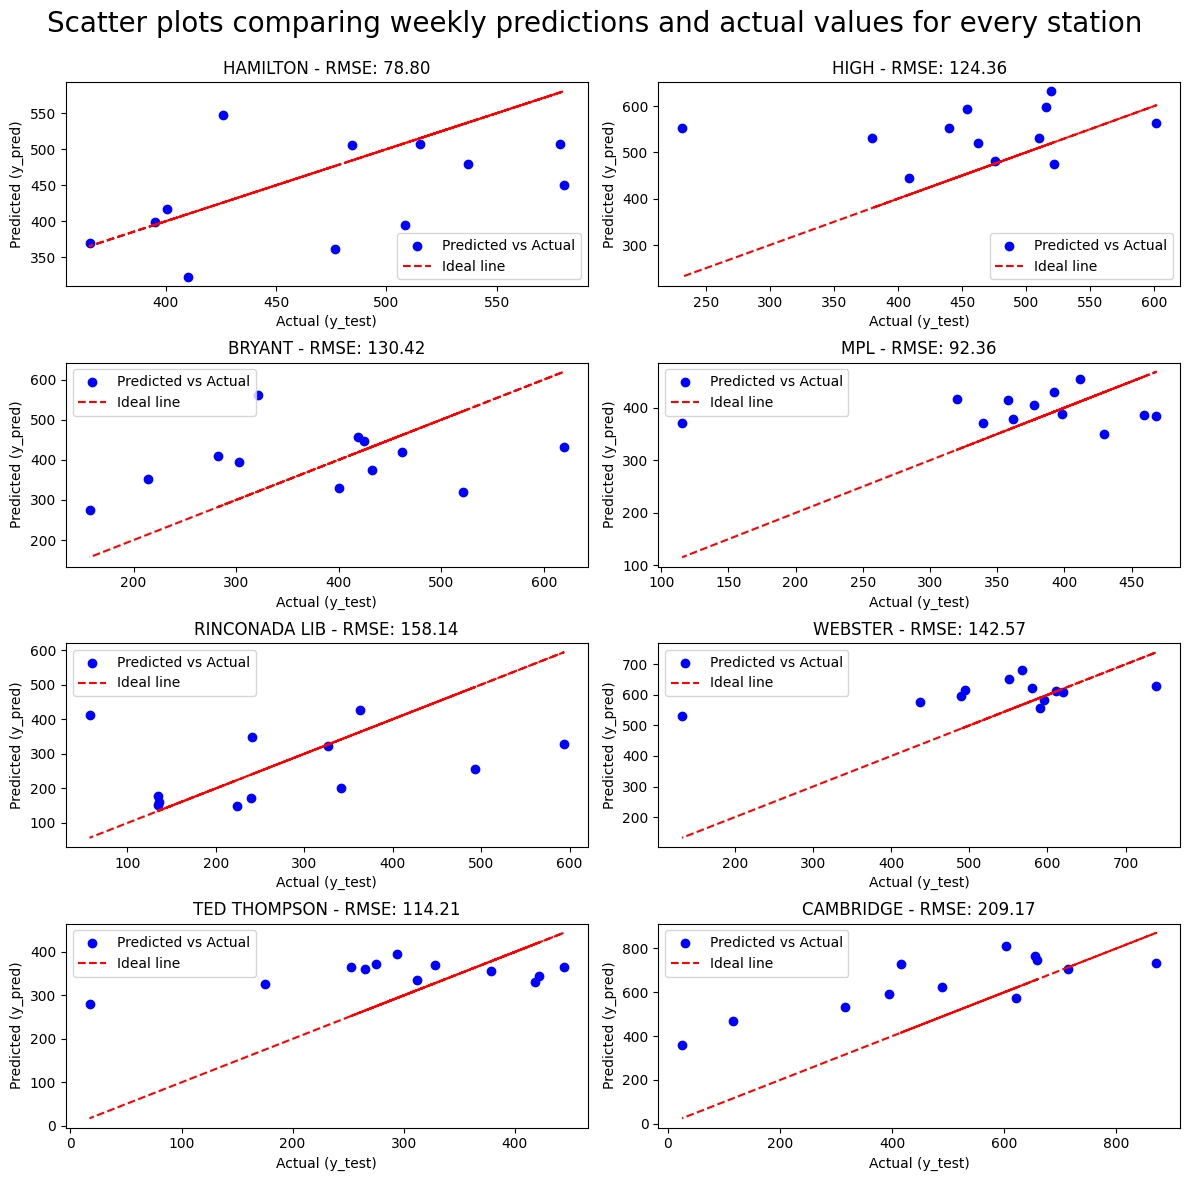

In [118]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 2

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(weekly_predictions_dict.keys()):
    # Get data for the current station
    station_data = weekly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot y_pred against y_test
    axs[i].scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    axs[i].plot(y_test, y_test, color='red', linestyle='--', label='Ideal line')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Actual (y_test)')
    axs[i].set_ylabel('Predicted (y_pred)')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Scatter plots comparing weekly predictions and actual values for every station', fontsize=20)
plt.show()

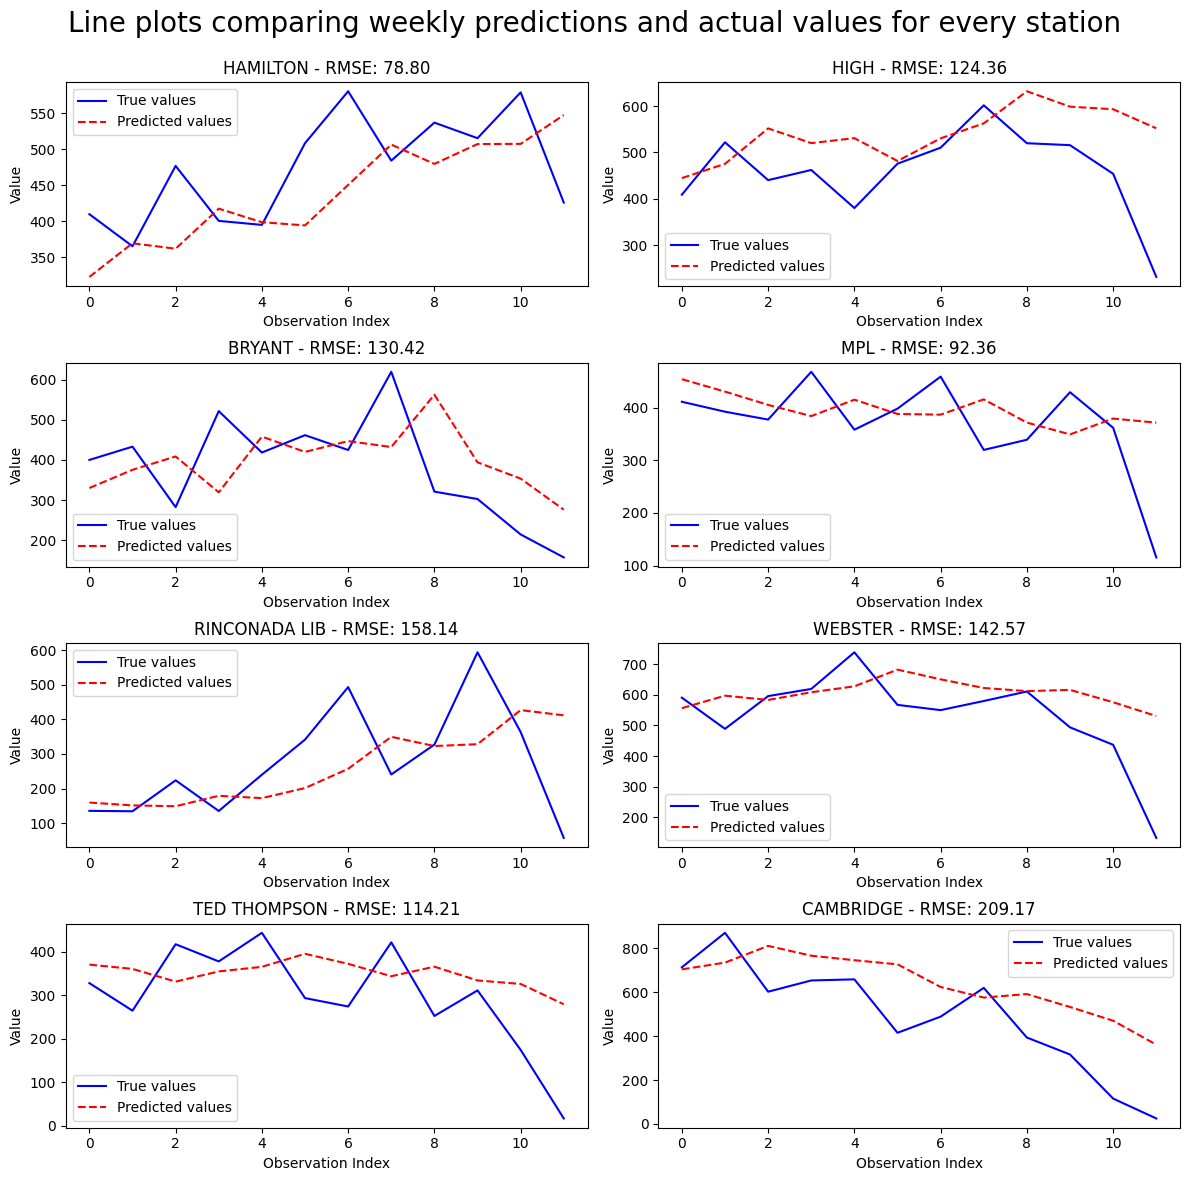

In [127]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 2

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(weekly_predictions_dict.keys()):
    # Get data for the current station
    station_data = weekly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot true values and predicted values against the index of observations
    x = np.arange(len(y_test))
    axs[i].plot(x, y_test, color='blue', label='True values')
    axs[i].plot(x, y_pred, color='red', linestyle='--', label='Predicted values')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Observation Index')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Line plots comparing weekly predictions and actual values for every station', fontsize=20)
plt.show()


The results are also good. Clearly the model sometimes fails to account for sudden drops or spikes but otherwise performs well. Note that the RMSE should not be compared directly to daily predictions as the scale of weekly demand is approximately 7 times larger than daily.

### Monthly predictions

Monthly model is trained to predict also based on only 6 previous observations due to time-range. Test set contains last 6 observations (rest is used for training). This time the model is trained even longer to achieve convergence - 300 epochs. The training output has been colapsed as it used only for diagnostics. Results are shown at the end.

In [122]:
# Initialize dict for storing predictions
monthly_predictions_dict = {}
for station in stations:
    monthly_predictions_dict[station] = {'y_test':[], 'y_pred':[], 'rmse':0}


 HAMILTON 

(101, 6, 1) (101, 1) (6, 6, 1) (6, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/300] - Training Loss: 0.0301, Test Loss: 0.1037
Epoch [20/300] - Training Loss: 0.0231, Test Loss: 0.0754
Epoch [30/300] - Training Loss: 0.0186, Test Loss: 0.0538
Epoch [40/300] - Training Loss: 0.0177, Test Loss: 0.0486
Epoch [50/300] - Training Loss: 0.0171, Test Loss: 0.0464
Epoch [60/300] - Training Loss: 0.0165, Test Loss: 0.0445
Epoch [70/300] - Training Loss: 0.0159, Test Loss: 0.0428
Epoch [80/300] - Training Loss: 0.0152, Test Loss: 0.0414
Epoch [90/300] - Training Loss: 0.0145, Test Loss: 0.0404
Epoch [100/300] - Training Loss: 0.0138, Test Loss: 0.0401
Epoch [110/300] - Training Loss: 0.0131, Test Loss: 0.0408
Epoch [120/300] - Training Loss: 0.0126, Test Loss: 0.0426
Epoch [130/300] - Training Loss: 0.0121, Test Loss: 0.0450
Epoch [140/300] - Training Loss: 0.0117, Test Loss: 0.0474
Epoch [150/300] - Training Loss: 0.0114, Test Loss: 0.0494
Epoch [160/300] - Training Loss: 0.0111, Test Loss: 0.0509
Epoch [170/300] - Training Loss: 0.0109, Test Loss: 0.0519
Epoch 

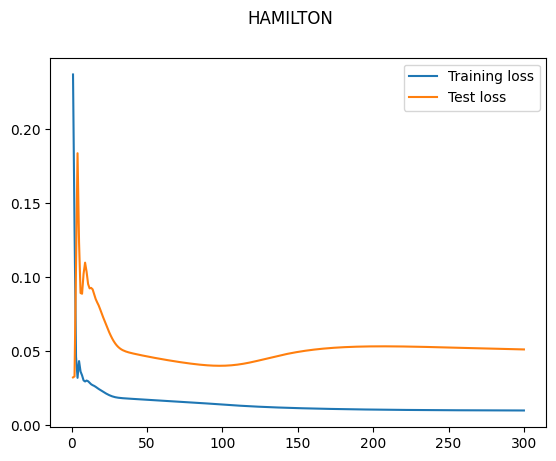

HAMILTON Root Mean Squared Error (RMSE): 954.2318719180515

 HIGH 

(100, 6, 1) (100, 1) (6, 6, 1) (6, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/300] - Training Loss: 0.0448, Test Loss: 0.0235
Epoch [20/300] - Training Loss: 0.0288, Test Loss: 0.0087
Epoch [30/300] - Training Loss: 0.0246, Test Loss: 0.0044
Epoch [40/300] - Training Loss: 0.0215, Test Loss: 0.0025
Epoch [50/300] - Training Loss: 0.0175, Test Loss: 0.0006
Epoch [60/300] - Training Loss: 0.0136, Test Loss: 0.0010
Epoch [70/300] - Training Loss: 0.0118, Test Loss: 0.0025
Epoch [80/300] - Training Loss: 0.0108, Test Loss: 0.0023
Epoch [90/300] - Training Loss: 0.0102, Test Loss: 0.0018
Epoch [100/300] - Training Loss: 0.0098, Test Loss: 0.0014
Epoch [110/300] - Training Loss: 0.0095, Test Loss: 0.0010
Epoch [120/300] - Training Loss: 0.0093, Test Loss: 0.0008
Epoch [130/300] - Training Loss: 0.0091, Test Loss: 0.0007
Epoch [140/300] - Training Loss: 0.0089, Test Loss: 0.0006
Epoch [150/300] - Training Loss: 0.0088, Test Loss: 0.0005
Epoch [160/300] - Training Loss: 0.0086, Test Loss: 0.0005
Epoch [170/300] - Training Loss: 0.0085, Test Loss: 0.0005
Epoch 

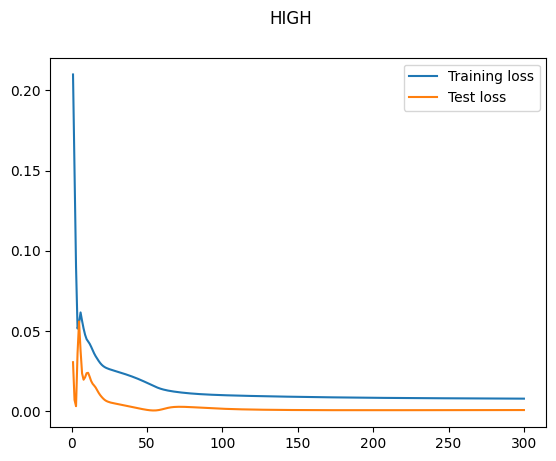

HIGH Root Mean Squared Error (RMSE): 219.79385999159513

 BRYANT 

(99, 6, 1) (99, 1) (6, 6, 1) (6, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/300] - Training Loss: 0.0362, Test Loss: 0.0665
Epoch [20/300] - Training Loss: 0.0280, Test Loss: 0.0360
Epoch [30/300] - Training Loss: 0.0234, Test Loss: 0.0189
Epoch [40/300] - Training Loss: 0.0222, Test Loss: 0.0143
Epoch [50/300] - Training Loss: 0.0213, Test Loss: 0.0120
Epoch [60/300] - Training Loss: 0.0203, Test Loss: 0.0100
Epoch [70/300] - Training Loss: 0.0193, Test Loss: 0.0080
Epoch [80/300] - Training Loss: 0.0182, Test Loss: 0.0060
Epoch [90/300] - Training Loss: 0.0170, Test Loss: 0.0040
Epoch [100/300] - Training Loss: 0.0158, Test Loss: 0.0023
Epoch [110/300] - Training Loss: 0.0148, Test Loss: 0.0011
Epoch [120/300] - Training Loss: 0.0141, Test Loss: 0.0008
Epoch [130/300] - Training Loss: 0.0138, Test Loss: 0.0008
Epoch [140/300] - Training Loss: 0.0135, Test Loss: 0.0009
Epoch [150/300] - Training Loss: 0.0133, Test Loss: 0.0009
Epoch [160/300] - Training Loss: 0.0131, Test Loss: 0.0008
Epoch [170/300] - Training Loss: 0.0130, Test Loss: 0.0008
Epoch 

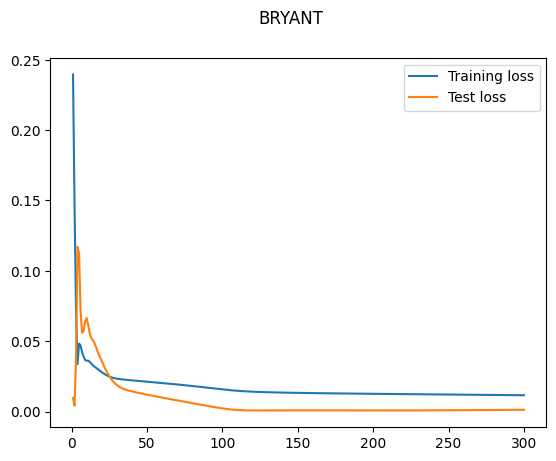

BRYANT Root Mean Squared Error (RMSE): 281.1814859457751

 MPL 

(64, 6, 1) (64, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0487, Test Loss: 0.0241


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0467, Test Loss: 0.0173
Epoch [30/300] - Training Loss: 0.0408, Test Loss: 0.0101
Epoch [40/300] - Training Loss: 0.0351, Test Loss: 0.0036
Epoch [50/300] - Training Loss: 0.0315, Test Loss: 0.0009
Epoch [60/300] - Training Loss: 0.0298, Test Loss: 0.0009
Epoch [70/300] - Training Loss: 0.0282, Test Loss: 0.0008
Epoch [80/300] - Training Loss: 0.0264, Test Loss: 0.0008
Epoch [90/300] - Training Loss: 0.0244, Test Loss: 0.0007
Epoch [100/300] - Training Loss: 0.0222, Test Loss: 0.0007
Epoch [110/300] - Training Loss: 0.0205, Test Loss: 0.0008
Epoch [120/300] - Training Loss: 0.0194, Test Loss: 0.0008
Epoch [130/300] - Training Loss: 0.0186, Test Loss: 0.0009
Epoch [140/300] - Training Loss: 0.0178, Test Loss: 0.0009
Epoch [150/300] - Training Loss: 0.0170, Test Loss: 0.0009
Epoch [160/300] - Training Loss: 0.0163, Test Loss: 0.0008
Epoch [170/300] - Training Loss: 0.0156, Test Loss: 0.0008
Epoch [180/300] - Training Loss: 0.0149, Test Loss: 0.0008
Epoch

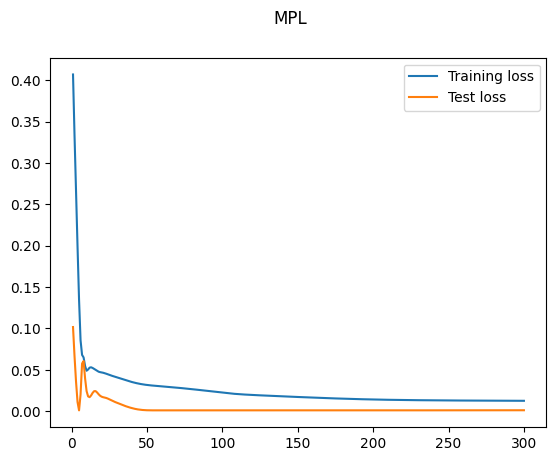

MPL Root Mean Squared Error (RMSE): 207.13566961928208

 RINCONADA LIB 

(55, 6, 1) (55, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0381, Test Loss: 0.1316


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0327, Test Loss: 0.1103
Epoch [30/300] - Training Loss: 0.0269, Test Loss: 0.0932
Epoch [40/300] - Training Loss: 0.0222, Test Loss: 0.0724
Epoch [50/300] - Training Loss: 0.0210, Test Loss: 0.0627
Epoch [60/300] - Training Loss: 0.0200, Test Loss: 0.0602
Epoch [70/300] - Training Loss: 0.0191, Test Loss: 0.0573
Epoch [80/300] - Training Loss: 0.0180, Test Loss: 0.0542
Epoch [90/300] - Training Loss: 0.0168, Test Loss: 0.0509
Epoch [100/300] - Training Loss: 0.0155, Test Loss: 0.0472
Epoch [110/300] - Training Loss: 0.0140, Test Loss: 0.0432
Epoch [120/300] - Training Loss: 0.0127, Test Loss: 0.0394
Epoch [130/300] - Training Loss: 0.0121, Test Loss: 0.0369
Epoch [140/300] - Training Loss: 0.0117, Test Loss: 0.0360
Epoch [150/300] - Training Loss: 0.0113, Test Loss: 0.0356
Epoch [160/300] - Training Loss: 0.0110, Test Loss: 0.0353
Epoch [170/300] - Training Loss: 0.0108, Test Loss: 0.0352
Epoch [180/300] - Training Loss: 0.0105, Test Loss: 0.0351
Epoch

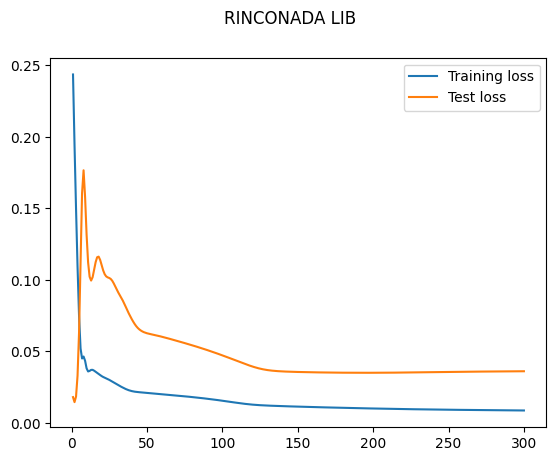

RINCONADA LIB Root Mean Squared Error (RMSE): 924.6292045345642

 WEBSTER 

(54, 6, 1) (54, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0451, Test Loss: 0.1219


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0445, Test Loss: 0.1032
Epoch [30/300] - Training Loss: 0.0425, Test Loss: 0.0873
Epoch [40/300] - Training Loss: 0.0402, Test Loss: 0.0726
Epoch [50/300] - Training Loss: 0.0378, Test Loss: 0.0583
Epoch [60/300] - Training Loss: 0.0355, Test Loss: 0.0443
Epoch [70/300] - Training Loss: 0.0332, Test Loss: 0.0316
Epoch [80/300] - Training Loss: 0.0314, Test Loss: 0.0229
Epoch [90/300] - Training Loss: 0.0297, Test Loss: 0.0186
Epoch [100/300] - Training Loss: 0.0279, Test Loss: 0.0162
Epoch [110/300] - Training Loss: 0.0259, Test Loss: 0.0143
Epoch [120/300] - Training Loss: 0.0236, Test Loss: 0.0126
Epoch [130/300] - Training Loss: 0.0215, Test Loss: 0.0111
Epoch [140/300] - Training Loss: 0.0200, Test Loss: 0.0099
Epoch [150/300] - Training Loss: 0.0193, Test Loss: 0.0097
Epoch [160/300] - Training Loss: 0.0188, Test Loss: 0.0103
Epoch [170/300] - Training Loss: 0.0184, Test Loss: 0.0109
Epoch [180/300] - Training Loss: 0.0181, Test Loss: 0.0116
Epoch

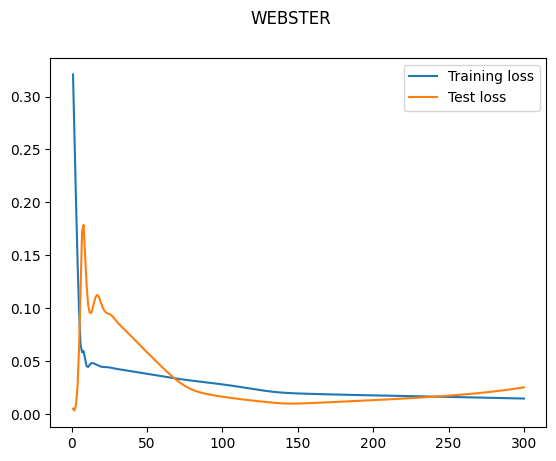

WEBSTER Root Mean Squared Error (RMSE): 1398.6860599861736

 TED THOMPSON 

(48, 6, 1) (48, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0843, Test Loss: 0.0650


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0804, Test Loss: 0.0527
Epoch [30/300] - Training Loss: 0.0770, Test Loss: 0.0480
Epoch [40/300] - Training Loss: 0.0731, Test Loss: 0.0417
Epoch [50/300] - Training Loss: 0.0682, Test Loss: 0.0343
Epoch [60/300] - Training Loss: 0.0620, Test Loss: 0.0264
Epoch [70/300] - Training Loss: 0.0540, Test Loss: 0.0196
Epoch [80/300] - Training Loss: 0.0443, Test Loss: 0.0161
Epoch [90/300] - Training Loss: 0.0375, Test Loss: 0.0150
Epoch [100/300] - Training Loss: 0.0337, Test Loss: 0.0123
Epoch [110/300] - Training Loss: 0.0303, Test Loss: 0.0111
Epoch [120/300] - Training Loss: 0.0273, Test Loss: 0.0103
Epoch [130/300] - Training Loss: 0.0244, Test Loss: 0.0094
Epoch [140/300] - Training Loss: 0.0219, Test Loss: 0.0083
Epoch [150/300] - Training Loss: 0.0198, Test Loss: 0.0071
Epoch [160/300] - Training Loss: 0.0181, Test Loss: 0.0057
Epoch [170/300] - Training Loss: 0.0167, Test Loss: 0.0044
Epoch [180/300] - Training Loss: 0.0157, Test Loss: 0.0032
Epoch

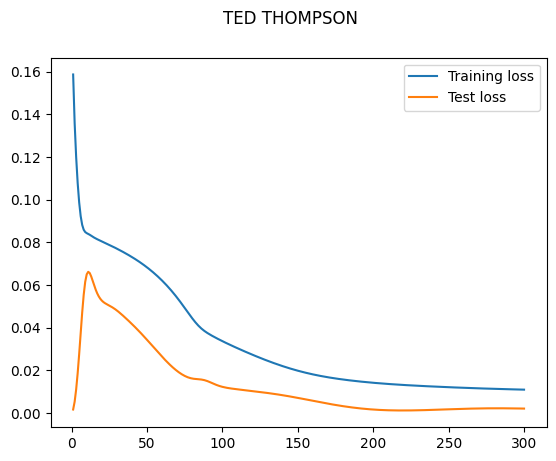

TED THOMPSON Root Mean Squared Error (RMSE): 213.07489277936554

 CAMBRIDGE 

(48, 6, 1) (48, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0712, Test Loss: 0.0326


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0666, Test Loss: 0.0203
Epoch [30/300] - Training Loss: 0.0648, Test Loss: 0.0199
Epoch [40/300] - Training Loss: 0.0629, Test Loss: 0.0206
Epoch [50/300] - Training Loss: 0.0606, Test Loss: 0.0216
Epoch [60/300] - Training Loss: 0.0579, Test Loss: 0.0229
Epoch [70/300] - Training Loss: 0.0546, Test Loss: 0.0250
Epoch [80/300] - Training Loss: 0.0510, Test Loss: 0.0282
Epoch [90/300] - Training Loss: 0.0472, Test Loss: 0.0325
Epoch [100/300] - Training Loss: 0.0436, Test Loss: 0.0358
Epoch [110/300] - Training Loss: 0.0404, Test Loss: 0.0361
Epoch [120/300] - Training Loss: 0.0376, Test Loss: 0.0342
Epoch [130/300] - Training Loss: 0.0353, Test Loss: 0.0319
Epoch [140/300] - Training Loss: 0.0335, Test Loss: 0.0298
Epoch [150/300] - Training Loss: 0.0319, Test Loss: 0.0280
Epoch [160/300] - Training Loss: 0.0305, Test Loss: 0.0263
Epoch [170/300] - Training Loss: 0.0292, Test Loss: 0.0247
Epoch [180/300] - Training Loss: 0.0277, Test Loss: 0.0229
Epoch

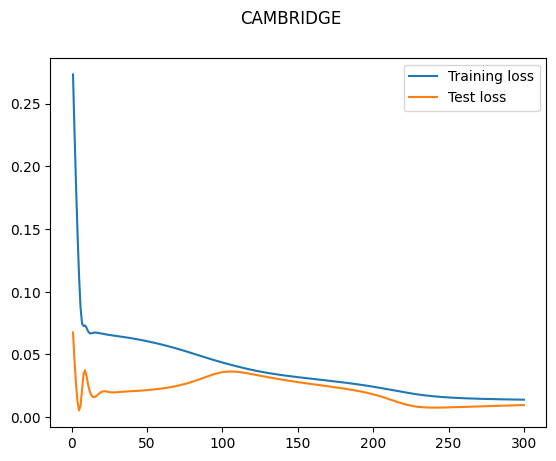

CAMBRIDGE Root Mean Squared Error (RMSE): 654.103174228136


In [123]:
train_lstm(df_dict=stations_dict, type='monthly',sequence_length=6, stations=stations, 
           num_epochs=300, predictions_dict=monthly_predictions_dict, test_obs=6)

In [124]:
# File path to save the dictionary
file_path = 'monthly_predictions_palo_alto.pkl'

# Save the dictionary to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(monthly_predictions_dict, file)

print(f"Dictionary saved to '{file_path}'")

Dictionary saved to 'monthly_predictions_palo_alto.pkl'


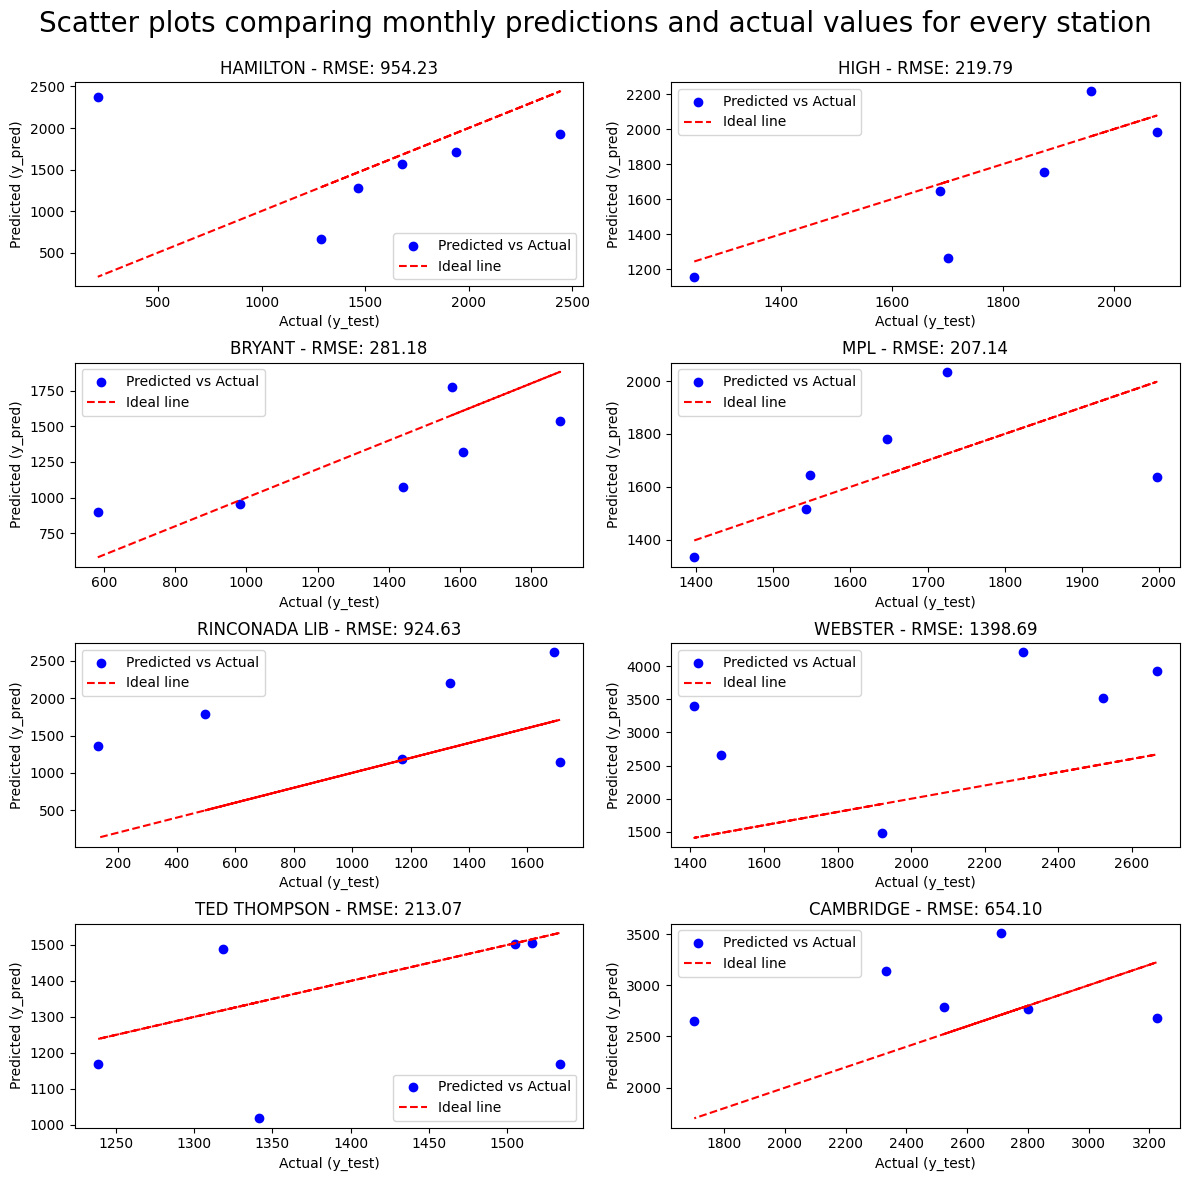

In [125]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 2

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(monthly_predictions_dict.keys()):
    # Get data for the current station
    station_data = monthly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot y_pred against y_test
    axs[i].scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    axs[i].plot(y_test, y_test, color='red', linestyle='--', label='Ideal line')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Actual (y_test)')
    axs[i].set_ylabel('Predicted (y_pred)')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Scatter plots comparing monthly predictions and actual values for every station', fontsize=20)
plt.show()

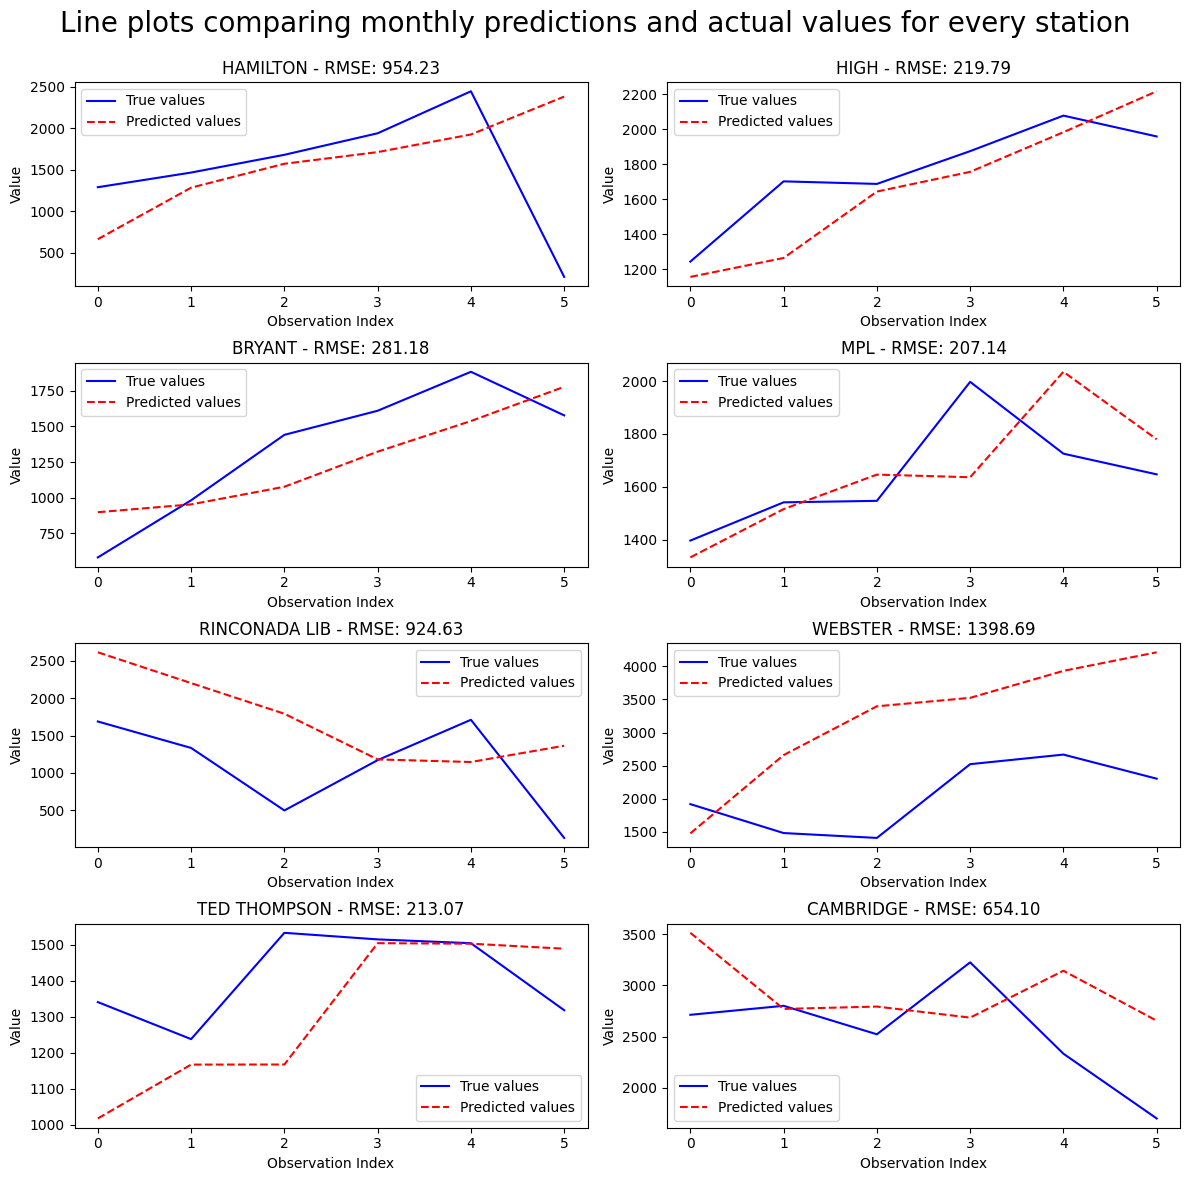

In [126]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 2

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(monthly_predictions_dict.keys()):
    # Get data for the current station
    station_data = monthly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot true values and predicted values against the index of observations
    x = np.arange(len(y_test))
    axs[i].plot(x, y_test, color='blue', label='True values')
    axs[i].plot(x, y_pred, color='red', linestyle='--', label='Predicted values')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Observation Index')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Line plots comparing monthly predictions and actual values for every station', fontsize=20)
plt.show()

Once again the model seems to be working fine for most stations with the exception of stations like e.g. WEBSTER. Again, the RMSE should not be directly compared between different timeframe models.

### Conclusions

The LSTM models seem suitable for energy demand forecasting. The predictions are of course not ideal but given the high variability of the demand are acceptable. Decent performance can be observed for all of the daily, weekly and monthly timeframes. All stations have more less similar performance but some like WEBSTER or RINCONADA underperform slightly. Models definately produce valuable forecasts which can be used to aid planning and logistics of providing the energy needed for the customers which in turn could translate to higher satisfaction of using electric cars.